### Table of Contents

* [1: Importing, Merging, and Cleaning the Data](#import_merge_clean_1)
    * [1.1: Import](#import_1_1)
    * [1.2: Merge](#merge_1_2)
        * [1.2.1: Merge HCPCS Codes](#merge_hcpcs_1_2_1)
        * [1.2.2: Merge Carrier Codes](#merge_carrier_1_2_2)
        * [1.2.3: Merge Locality Codes](#merge_locality_1_2_3)
    * [1.3: Clean](#clean_1_3)
* [2: Visualization](#vis_2)
    * [2.1: Nation-Wide](#vis_nation_2_1)
    * [2.2: Statewide](#vis_state_2_2)
    * [2.3: Citywide](#vis_city_2_3)
* [3: Business Application](#business_app_3)
    * [3.1: Revenue Forecasting](#business_app_rev_3_1)
    * [3.2: Statewide](#business_app_rev_3_2)

### 1 - Importing, Merging, and Cleaning the Data<a class="anchor" id="import_merge_clean_1"></a>

#### 1.1 - Import<a class="anchor" id="import_1_1"></a>
* Download Ambulance Fee Schedule from [The Centers for Medicare & Medicaid Services](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/), CMS

In [1]:
# List of urls to Ambulance Fee Schedule data
lst_url = ['https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/afs_2005.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2006_afs.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2007_afs.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2008_Ambulance_Fee_Schedule_PUF_update.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2009_AFS_PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2010_AFS_PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2011_AFS_PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2012_AFS_PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2013-AFS-PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2014-AFS-PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2015-AFS-PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2016-AFS-PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/CY-2017-File.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2018-AFS-PUF.zip',
          'https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AmbulanceFeeSchedule/Downloads/2019-AFS-PUF.zip',
          'https://www.cms.gov/files/zip/cy-2020-file.zip']

# Import the data using the wget package
# !pip install wget
import wget
for url in lst_url:
    wget.download(url)
    file_name = url.split('/')[-1]
    print(f'Downloaded: {file_name}')
    
# Get list of zip files in current directory (name changes from website to here)
import os
zip_files = [f for f in os.listdir('.') if os.path.isfile(f) and f[-3:]=='zip'];

# Extract zip files to data folder
import zipfile
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('data')
        
# Delete zip files
for file in zip_files:
    os.remove(file)

# Rename relevant spreadsheets
os.rename('./data/' + 'ambfspuf_2013_2ndrevisedfinal.xlsx', './data/' + '2013.xlsx')
os.rename('./data/' + 'ambfspuf 1Q2014_ext_finalv2.xlsx', './data/' + '2014.xlsx')
os.rename('./data/' + 'ambfspuf_2016_.xlsx', './data/' + '2016.xlsx')

# Delete non txt files
non_txt_files = [f for f in os.listdir('./data/') if f[-3:]!='txt']
txt_files = [f for f in os.listdir('./data/') if f[-3:]=='txt']
keep_files = ['2013.xlsx', '2014.xlsx', '2016.xlsx']
for file in non_txt_files:
    if file not in keep_files:
        os.remove('./data/' + file)

# Rename txt files for redability
txt_files_rename = []
for file in txt_files:
    s = ''.join([i for i in file if i.isnumeric()])
    idx_yr = s.find('2')
    s = s[idx_yr:idx_yr + 4] + '.txt'
    txt_files_rename.append(s)
txt_files_rename
for i in range(len(txt_files)):
    os.rename('./data/' + txt_files[i], './data/' + txt_files_rename[i])
    
# Delete non-needed txt files
os.remove('./data/8.txt')
os.remove('./data/2013.txt')
os.remove('./data/2014.txt')
os.remove('./data/2016.txt')

Downloaded: afs_2005.zip
Downloaded: 2006_afs.zip
Downloaded: 2007_afs.zip
Downloaded: 2008_Ambulance_Fee_Schedule_PUF_update.zip
Downloaded: 2009_AFS_PUF.zip
Downloaded: 2010_AFS_PUF.zip
Downloaded: 2011_AFS_PUF.zip
Downloaded: 2012_AFS_PUF.zip
Downloaded: 2013-AFS-PUF.zip
Downloaded: 2014-AFS-PUF.zip
Downloaded: 2015-AFS-PUF.zip
Downloaded: 2016-AFS-PUF.zip
Downloaded: CY-2017-File.zip
Downloaded: 2018-AFS-PUF.zip
Downloaded: 2019-AFS-PUF.zip
Downloaded: cy-2020-file.zip


#### Create dataframe for each year

In [2]:
# Clean data and create dataframe for each year
import pandas as pd

# Create list of years with associated txt files
lst_txt = [2009, 2010, 2011, 2015, 2012, 2017, 2018, 2019, 2020]

# Create list of years with associated xlsx files
lst_xlsx = [2013, 2014, 2016,]

# Create pandas df for each txt file / year
for yr in lst_txt:
    df_name = 'df_' + str(yr)
    globals()[df_name] = pd.read_csv('./data/' + str(yr) + '.txt', sep="\t", dtype={'CONTRACTOR/CARRIER': str,'contractor/carrier': str})
    globals()[df_name] = globals()[df_name].iloc[:, : 10]
    # Need to treat differently due to order of columns being different
    if yr>=2017:
        col_correct_order = ['CONTRACTOR/CARRIER', 'LOCALITY', 'HCPCS', 'BASE RATE', 'RVU', 'GPCI', 'URBAN BASE RATE / URBAN MILEAGE', 'RURAL BASE RATE / RURAL MILEAGE', 'RURAL BASE RATE / LOWEST QUARTILE', 'RURAL GROUND MILES 1-17*']
        globals()[df_name] = globals()[df_name][col_correct_order]
    
# Create pandas df for each xlsx file / year
for yr in lst_xlsx:
    df_name = 'df_' + str(yr)
    globals()[df_name] = pd.read_excel('./data/' + str(yr) + '.xlsx')
    globals()[df_name] = globals()[df_name].iloc[:, : 10]

# Create list of all dataframes
lst_df = [df_2009,df_2010,df_2011,
          df_2012,df_2013,df_2014,
          df_2015,df_2016,df_2017,
          df_2018,df_2019,df_2020]

# Create list of column names to superimpose on each df for consistency
col_consistent = ['contractor/carrier', 'locality', 'hcpcs', 'base rate', 'rvu', 'gpci', 'urban base rate / urban mileage', 'rural base rate / rural mileage', 'rural base rate / lowest quartile', 'rural ground miles']

# Assign column names to each dataframe
for i in range(len(lst_df)):
    lst_df[i].columns = col_consistent
    # Convert locality to float
    lst_df[i]['locality'] = lst_df[i]['locality'].astype(float)
    # Found ID errors in data
    lst_df[i]['contractor/carrier'] = lst_df[i]['contractor/carrier'].astype(str).str.replace('01112', '01102').str.replace('10112', '10102').str.replace('10212', '10202').str.replace('10312', '10302')
    # Remove $ signs and convert to float
    lst_df[i]['base rate'] = lst_df[i]['base rate'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    lst_df[i]['urban base rate / urban mileage'] = lst_df[i]['urban base rate / urban mileage'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    lst_df[i]['rural base rate / rural mileage'] = lst_df[i]['rural base rate / rural mileage'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    lst_df[i]['rural base rate / lowest quartile'] = lst_df[i]['rural base rate / lowest quartile'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    lst_df[i]['rural ground miles'] = lst_df[i]['rural ground miles'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    
# Some dataframes have labels for various states and NA values following. Delete these rows
for i in range(len(lst_df)):
    lst_df[i] = lst_df[i].loc[~lst_df[i]['locality'].isna()]

#### 1.2 - Merge<a class="anchor" id="merge_1_2"></a>

##### 1.2.1 - Merge HCPCS Codes<a class="anchor" id="merge_hcpcs_1_2_1"></a>
* "HCPCS is a collection of standardized codes that represent medical procedures, supplies, products and services." [source](https://www.nlm.nih.gov/research/umls/sourcereleasedocs/current/HCPCS/index.html#:~:text=HCPCS%20is%20a%20collection%20of,by%20Medicare%20and%20other%20insurers.&text=HCPCS%20is%20divided%20into%20two%20subsystems%2C%20Level%20I%20and%20Level%20II.)
* Join Alpha-Numeric HCPCS Codes (i.e. all the different activities to be billed) [download](https://www.cms.gov/Medicare/Coding/HCPCSReleaseCodeSets/Alpha-Numeric-HCPCS)

In [3]:
# Import HCPCS Code dataframe
df_code = pd.read_excel('./_hcpcs/HCPCS_2020.xlsx')

# Lowercase column names
df_code.columns = df_code.columns.str.lower()

# Merge HCPCS dataframe with main dataframe
lst_yrs = [yr for yr in range(2009,2020+1)]
for i in range(len(lst_yrs)):
    lst_df[i] = pd.merge(lst_df[i], df_code[['hcpc/mod', 'short description', 'long description']], how='left', left_on='hcpcs', right_on='hcpc/mod')

##### 1.2.2 - Merge Carrier Codes<a class="anchor" id="merge_carrier_1_2_2"></a>
* Import contractor/carrier code data and perform string manipulation

In [4]:
# Loop through 2009-2016 years, save as dataframe, and performe string manipulation
for yr in lst_yrs:
    df_name = 'df_carrier_code_' + str(yr)
    try:
        globals()[df_name] = pd.read_csv('./_index/' + str(yr) + '.csv', header=None)
    except:
        globals()[df_name] = pd.read_excel('./_index/' + str(yr) + '.xlsx', header=None)
    
    # new data frame with split value columns 
    split_columns = globals()[df_name][0].str.split(" ", n = 1, expand = True)
    
    # making separate contractor/carrier column from new data frame 
    globals()[df_name]["contractor/carrier"] = split_columns[0]
    globals()[df_name]["contractor/carrier"] = globals()[df_name]["contractor/carrier"].astype(str).str.replace('U', '').str.strip()
    # Found ID errors in data
    globals()[df_name]['contractor/carrier'] = globals()[df_name]['contractor/carrier'].str.replace('0632', '06302').str.replace('01112', '01102')
    
    # making separate location column from new data frame 
    globals()[df_name]["contractor/carrier name"]= split_columns[1].str.replace('\d+', '').str.replace('-', '').str.strip().str.replace('-', '').str.lower()
    
    # reducing number of columns in data frame
    globals()[df_name] = globals()[df_name][["contractor/carrier", "contractor/carrier name"]]

# Create list of dataframes for convenient merging
lst_carrier_df = [df_carrier_code_2009,df_carrier_code_2010,df_carrier_code_2011,
                  df_carrier_code_2012,df_carrier_code_2013,df_carrier_code_2014,
                  df_carrier_code_2015,df_carrier_code_2016,df_carrier_code_2017,
                  df_carrier_code_2018,df_carrier_code_2019,df_carrier_code_2020]

#  Merge the datasets
for i in range(len(lst_yrs)):
    lst_df[i] = pd.merge(lst_df[i], lst_carrier_df[i], how='left', left_on='contractor/carrier', right_on='contractor/carrier')

##### 1.2.3 - Merge Locality Codes<a class="anchor" id="merge_locality_1_2_3"></a>

In [5]:
import numpy as np

# Create pandas df for each txt file / year
for yr in lst_yrs:
    df_name = 'df_' + str(yr) + '_locality'
    globals()[df_name] = pd.read_csv('./_locality/RVU' + str(yr)[-2:] + '/' + str(yr)[-2:] + 'LOCCO.csv')
    # Drop rows with all NA or all ' '
    globals()[df_name].replace(' ', np.NaN, inplace=True)
    globals()[df_name].dropna(how = 'all', inplace = True)
    # Convert locality number to float for merging
    globals()[df_name]['Locality Number'] = globals()[df_name]['Locality Number'].astype(float)
    # Need Carrier Codes to be 5 in length
    globals()[df_name]['Carrier Number'] = '000000' + globals()[df_name]['Carrier Number']
    globals()[df_name]['Carrier Number'] = globals()[df_name]['Carrier Number'].str[-5:]
    # Found ID errors in data
    globals()[df_name]['Carrier Number'] = globals()[df_name]['Carrier Number'].astype(str).str.replace('01112', '01102').str.replace('10112', '10102').str.replace('10212', '10202').str.replace('10312', '10302').str.replace('00590', '09102').str.replace('00973', '09202')
    # Convert column names to lower case
    globals()[df_name].columns = [i.lower() for i in globals()[df_name].columns]
    # Rename columns
    globals()[df_name].rename(columns={"fee schedule area ": "locality name"}, inplace=True)
    # Convert Locality Name to lowercase
    globals()[df_name]['locality name'] = globals()[df_name]['locality name'].str.lower()

lst_locality_df = [df_2009_locality,df_2010_locality,df_2011_locality,
                   df_2012_locality,df_2013_locality,df_2014_locality,
                   df_2015_locality,df_2016_locality,df_2017_locality,
                   df_2018_locality,df_2019_locality,df_2020_locality]

#  Merge the datasets
for i in range(len(lst_yrs)):
    lst_df[i] = pd.merge(lst_df[i], lst_locality_df[i], how='left', left_on=['contractor/carrier', 'locality'], right_on=['carrier number', 'locality number'])

#### 1.3 - Clean<a class="anchor" id="clean_1_3"></a>

In [6]:
# Create list of column names for an intuitive reordering
col_reorder = ['year','contractor/carrier','contractor/carrier name',
               'locality','locality name', 'hcpcs','short description','long description',
               'base rate','rvu','gpci','urban base rate / urban mileage',
               'rural base rate / rural mileage','rural base rate / lowest quartile',
               'rural ground miles']

# Reorder columns
for i in range(len(lst_yrs)):
    lst_df[i]['year'] = lst_yrs[i]
    lst_df[i] = lst_df[i][col_reorder]
    
# Compile all dataframes
df = pd.concat(lst_df)

# Some locality names are 'city' others are 'city, state'. Make these consistent
df['locality name'] = df['locality name'].str.split(",", n = 1, expand = True) 

# Remove 2009 due to noise in base rate
df = df.loc[df['year'] > 2009]

# Show sample
df.sample(3)

,year,contractor/carrier,contractor/carrier name,locality,locality name,hcpcs,short description,long description,base rate,rvu,gpci,urban base rate / urban mileage,rural base rate / rural mileage,rural base rate / lowest quartile,rural ground miles
1243,2018,13292,ghi/new york,4.0,queens,A0432,Pi volunteer ambulance co,"Paramedic intercept (pi), rural area, transpor...",224.74,1.75,1.200,457.320000,461.810000,NaN,NaN
556,2014,06202,minnesota,0.0,statewide,A0429,Bls-emergency,"Ambulance service, basic life support, emergen...",218.35,1.60,1.016,360.338289,363.871017,446.105867,NaN
889,2018,08102,indiana,0.0,statewide,A0426,Als 1,"Ambulance service, advanced life support, non-...",224.74,1.20,0.919,259.480000,262.030000,321.250000,NaN


### 2 - Visualization<a class="anchor" id="vis_2"></a>

#### In order to proceed with our analysis let us define the features in our data
* *Year* - Year of fee schedule

* *Contractor/Carrier* - Entity which has the responsibility for adjudicating and paying claims within a defined geographical location

* *Locality* - This field represents subsets of locations within a defined jurisdiction with different GPCI

* *HCPCS* - This field has the full range of HCPCS services payable under the ambulance fee schedule
    * "HCPCS is a collection of standardized codes that represent medical procedures, supplies, products and services." [source](https://www.nlm.nih.gov/research/umls/sourcereleasedocs/current/HCPCS/index.html#:~:text=HCPCS%20is%20a%20collection%20of,by%20Medicare%20and%20other%20insurers.&text=HCPCS%20is%20divided%20into%20two%20subsystems%2C%20Level%20I%20and%20Level%20II.)
    
* *Relative Value Unit (RVU)* - Ratio from 1 - 3.25 rating the complexity or cost of a given ambulance ride (i.e. a normal ambulance ride has an RVU of 1). The RVU Values are:
    * BLS (A0428) 1.00 
    * ALS1 (A0426) 1.20 
    * BLS - Emergency (A0429) 1.60 
    * PI (A0432) 1.75
    * ALS1- Emergency (A0427) 1.90 
    * ALS2 (A0433) 2.75 
    * SCT (A0434) 3.25 
    
* *Geographic Practice Cost Index (GPCI)* - "Inflation factor" to adjust payment to account for regional differences

* *Base Rate* - The Base Rate is a nationally uniform “base” amount used to calculate each HCPCS’ payment amount

* *Urban Base Rate / Mileage* - Equation that calculates urban fee rate based on RVU, GPCI, and National Base Rate

* *Rural Base Rate / Mileage* - Equation that calculates rural fee rate based on RVU, GPCI, and National Base Rate

* *Rural Base Rate / Lowest Quartile* - This field displays the rural base rate adjusted by the “super-rural bonus” multiplier of 22.6%. This is to incentivize medical services in sparsely populated areas

* *Rural Ground Miles* - This field displays the amounts for rural ground miles 1-17


#### 2.1 - Nation-Wide<a class="anchor" id="vis_nation_2_1"></a>

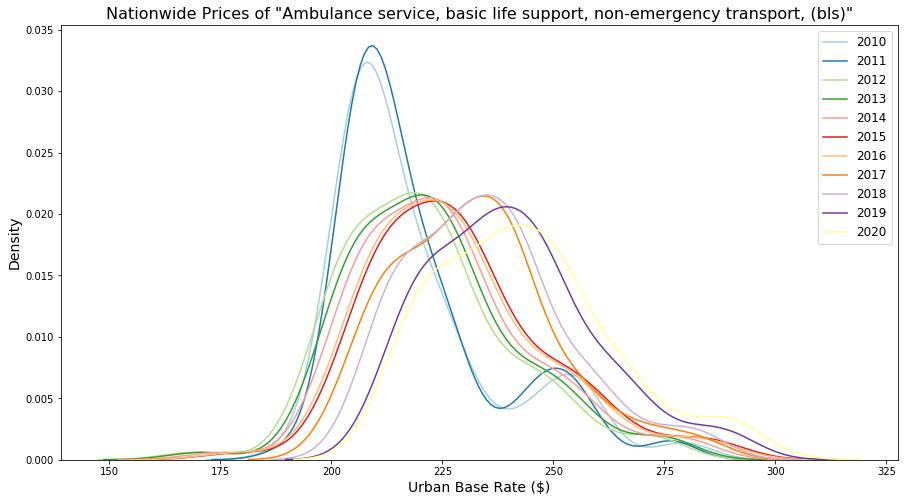

In [8]:
# Import necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Paired")

# Create standard font sizes for figures
SMALL_SIZE = 10
MEDIUM_SIZE = 13
BIGGER_SIZE = 16

# Create for loop to append pd series of median 'cost' of basic life support services for each year across the nation
lst = []
for yr in lst_yrs[1:]:
    median = df.loc[(df['hcpcs']=='A0428') & (df['year'] == yr)]['urban base rate / urban mileage'].median()
    vals = df.loc[(df['hcpcs']=='A0428') & (df['year'] == yr)][['urban base rate / urban mileage']].values.flatten()
    lst.append(vals)


# Create figure and define size
plt.figure(figsize=(15,8))

# Iterate through the all years to plot kde histogram of basic life support cost
for i in range(len(lst)):
   
    # Draw the density plot
    sns.distplot(lst[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
                 label = lst_yrs[i+1])
    
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Nationwide Prices of "' + df.loc[df['hcpcs']=='A0428']['long description'].values[0] + '"', size=BIGGER_SIZE)
plt.xlabel('Urban Base Rate ($)', fontsize=BIGGER_SIZE-2)
plt.ylabel('Density', fontsize=BIGGER_SIZE-2)
plt.show()

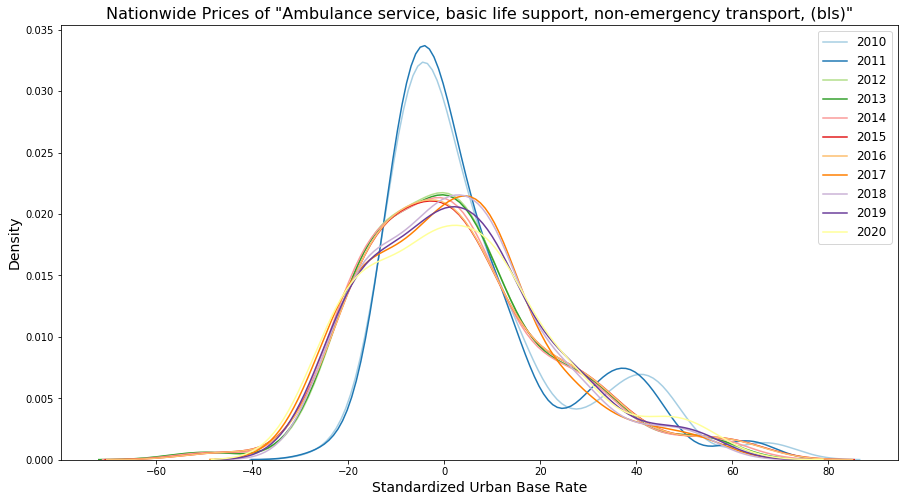

In [27]:
# Create for loop to append pd series of normalized 'cost' of basic life support services for each year across the nation
lst = []
for yr in lst_yrs[1:]:
    median = df.loc[(df['hcpcs']=='A0428') & (df['year'] == yr)]['urban base rate / urban mileage'].median()
    vals = df.loc[(df['hcpcs']=='A0428') & (df['year'] == yr)][['urban base rate / urban mileage']].values.flatten()
    vals = vals - median
    lst.append(vals)

# Create figure and define size
plt.figure(figsize=(15,8))

# Iterate through the all years to plot kde histogram of basic life support cost
for i in range(len(lst)):
   
    # Draw the density plot
    sns.distplot(lst[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1.5},
                 label = lst_yrs[i+1])
    
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Nationwide Prices of "' + df.loc[df['hcpcs']=='A0428']['long description'].values[0] + '"', size=BIGGER_SIZE)
plt.xlabel('Standardized Urban Base Rate', fontsize=BIGGER_SIZE-2)
plt.ylabel('Density', fontsize=BIGGER_SIZE-2)
plt.show()

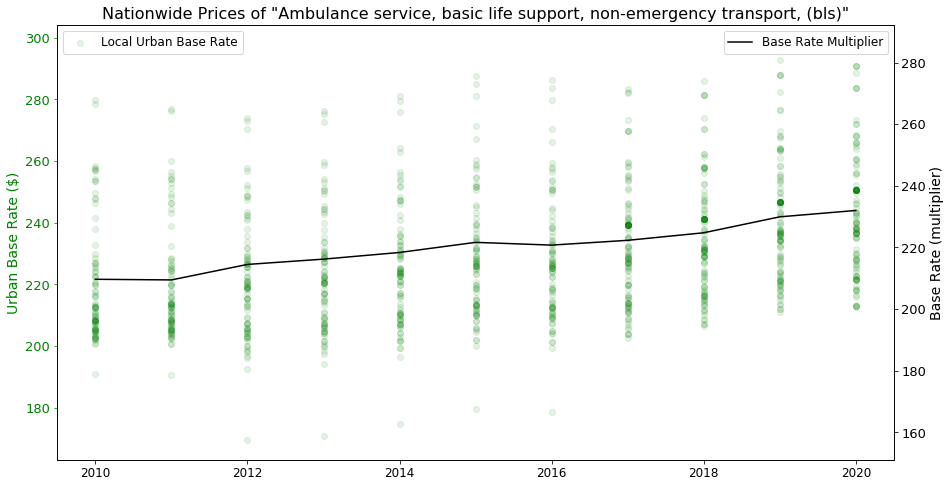

In [28]:
# Create new dataframe which only has 'Basic Life Support Services'
df_temp = df.loc[df['hcpcs']=='A0428'].copy()

# Create figure instance
fig, ax = plt.subplots(figsize=(15,8))

# Create scatter plot of urban base rate prices (Cost vs. Year)
x = df_temp['year']
y = df_temp['urban base rate / urban mileage']
ax.scatter(x, y, color='g', alpha=0.1, label='Local Urban Base Rate')
ax.set_ylabel('Urban Base Rate ($)', color="g",fontsize=BIGGER_SIZE-2)
ax.tick_params(axis='y', colors='g', labelsize=MEDIUM_SIZE)
ax.tick_params(axis='x', labelsize=12)
plt.legend(prop={'size': 12})

# Create plot of base rate increases on secondary y axis
ax2=ax.twinx()
ax2.plot(x, df_temp['base rate'], color="k", label='Base Rate Multiplier')
ax2.set_ylabel("Base Rate (multiplier)",color="k",fontsize=BIGGER_SIZE-2)
ax2.tick_params(axis='y', colors='k', labelsize=MEDIUM_SIZE)
# Set second y axis to be on same scale as first for comparison
median = df_temp['base rate'].median()
dif = ax.get_ylim()[1] - ax.get_ylim()[0]
ax2.set_ylim(median - dif/2, median + dif/2)
plt.legend(prop={'size': 12})

# Plot formatting
plt.xlabel('Year')
plt.title('Nationwide Prices of "' + df.loc[df['hcpcs']=='A0428']['long description'].values[0] + '"', size=BIGGER_SIZE)
plt.show()

#### 2.2 - Statewide<a class="anchor" id="vis_state_2_2"></a>

In [13]:
# Create function to plot time series of costs for a particular location and a particular HCPCS code
def state_time_plotter(hcpcs='A0428', carrier='texas', df=df):
    
    # Define temporary df filtered by HCPCS code and carrier (i.e. state)
    df_temp = df.loc[(df['hcpcs']==hcpcs) & (df['contractor/carrier name'] == carrier)].copy()
    try:
        # Reformat name to uppercase and define str variable for title of plot
        name = df.loc[(df['hcpcs']==hcpcs) & (df['contractor/carrier name'] == carrier)]['contractor/carrier name'].values[0]
        name = name[0].upper() + name[1:]
    except:
        # If the user enters an unknown carrier / state ...
        return 'No data for this carrier'

    # Create figure instance
    fig, ax = plt.subplots(figsize=(15,8))

    # Create scatter plot of urban mileage prices
    x = df_temp['year']
    y = df_temp['urban base rate / urban mileage']
    ax.scatter(x, y, color='g', alpha=0.9, label='Local Urban Base Rate')
    ax.set_ylabel('Urban Base Rate ($)', color="g",fontsize=BIGGER_SIZE-2)
    ax.tick_params(axis='y', colors='g', labelsize=MEDIUM_SIZE)
    ax.tick_params(axis='x', labelsize=12)
    plt.legend(prop={'size': 12})
    
    # Create plot of base rate increases on secondary y axis
    ax2=ax.twinx()
    ax2.plot(x, df_temp['base rate'], color="k", label='Base Rate Multiplier')
    ax2.set_ylabel("Base Rate (multiplier)",color="k",fontsize=BIGGER_SIZE-2)
    ax2.tick_params(axis='y', colors='k', labelsize=MEDIUM_SIZE)
    # Set second y axis to be on same scale as first for comparison
    median = df_temp['base rate'].median()
    dif = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax2.set_ylim(median - dif/2, median + dif/2)

    # Plot formatting
    plt.xlabel('Year')
    plt.title(name + ' Prices for "' + df_temp.loc[df_temp['hcpcs']==hcpcs]['long description'].values[0] + '"', size=BIGGER_SIZE)
    plt.legend(prop={'size': 12})
    plt.show()

In [60]:
# List all states in the dataset for a user to plot with them
lst_states = sorted(df['contractor/carrier name'].unique().tolist())
print('All states in the dataset: \n')
for x in lst_states:
    print(x, end=' || ')

All states in the dataset: 

alabama || alaska || arizona || arkansas || colorado || connecticut || delaware || district of columbia || empire new york || florida || georgia || ghi/new york || hawaii/guam || idaho || illinois || indiana || iowa || kansas || kentucky || louisiana || maine || maryland || massachusetts || michigan || minnesota || mississippi || missouri || montana || nebraska || nevada || new hampshire || new jersey || new mexico || north carolina || north dakota || northern california || ohio || oklahoma || oregon || pennsylvania || puerto rico/virgin islands || rhode island || south carolina || south dakota || southern california || tennessee || texas || utah || vermont || virginia || washington || west virginia || western new york || wisconsin || wyoming || 

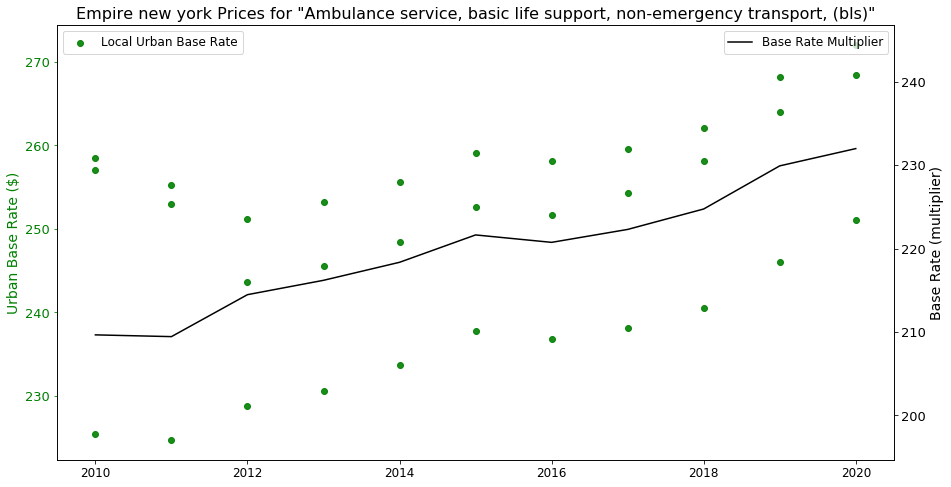

In [61]:
# Call the state_time_plotter function with HCPCS and state of interest
state_time_plotter(hcpcs='A0428', carrier='empire new york')

In [62]:
# Create a function to create a bar plot of ambulance fees for a particular year and state
def state_bar_plotter(year=2020, carrier='texas'):
    
    # List of ambulance fees not to include in visualization (due to being per mile costs)
    lst = ['A0436', 'A0435', 'A0425']
    
    # Create temporary df with year and state of interest
    df_temp = df.loc[(df['year']==year) & (df['contractor/carrier name'] == carrier) & (~df['hcpcs'].isin(lst))].copy()
    
    # Perform groupby to find median cost for state. Grouped by HCPCS description
    data = df_temp.groupby(['short description'])[['urban base rate / urban mileage']].median().sort_values("urban base rate / urban mileage")
    name = df_temp['contractor/carrier name'].values[0]
    name = name[0].upper() + name[1:]
    
    # Create horizontal bar plot
    data.plot.barh(figsize=(12,8), color='b', alpha=0.4, fontsize=MEDIUM_SIZE)
    
    # Format plot
    plt.title('Median Fee for Ambulance Services in ' + name, fontsize=BIGGER_SIZE)
    plt.xlabel('Cost ($)', fontsize=MEDIUM_SIZE)
    plt.ylabel('')
    plt.legend(prop={'size': 12}, loc=4)
    plt.show()

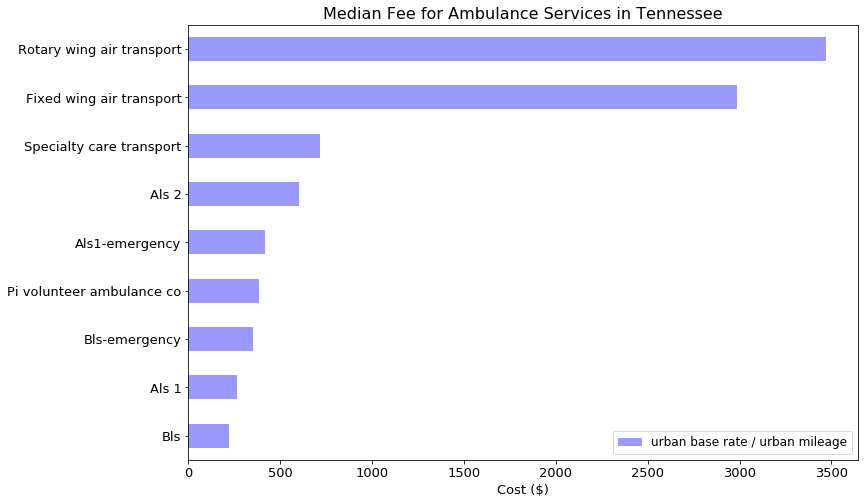

In [63]:
# Call the state_bar_plotter for the year and state of interest
state_bar_plotter(year=2020, carrier='tennessee')

#### 2.3 - Citywide<a class="anchor" id="vis_city_2_3"></a>

In [64]:
# Create function to plot time series of costs for a particular city and a particular HCPCS code
def city_time_plotter(hcpcs='A0428', carrier='texas', locality='austin', df=df):
    
    # Define temporary df filtered by HCPCS code, carrier (i.e. state), and locality (i.e. city)
    df_temp = df.loc[(df['hcpcs']==hcpcs) & (df['contractor/carrier name'] == carrier) & (df['locality name'] == locality)].copy()
    try:
        # Reformat name to uppercase and define str variable for title of plot
        name = df.loc[(df['hcpcs']==hcpcs) & (df['contractor/carrier name'] == carrier) & (df['locality name'] == locality)]['locality name'].values[0]
        name = name[0].upper() + name[1:]
    except:
        # If the user enters an unknown carrier / state ...
        return 'No data for this carrier'

    # Create figure instance
    fig, ax = plt.subplots(figsize=(15,8))

    # Create scatter plot of urban mileage prices
    x = df_temp['year']
    y = df_temp['urban base rate / urban mileage']
    ax.scatter(x, y, color='g', alpha=0.9, label='Local Urban Base Rate')
    ax.set_ylabel('Urban Base Rate ($)', color="g",fontsize=BIGGER_SIZE-2)
    ax.tick_params(axis='y', colors='g', labelsize=MEDIUM_SIZE)
    ax.tick_params(axis='x', labelsize=12)
    plt.legend(prop={'size': 12})
    
    # Create plot of base rate increases on secondary y axis
    ax2=ax.twinx()
    ax2.plot(x, df_temp['base rate'], color="k", label='Base Rate Multiplier')
    ax2.set_ylabel("Base Rate (multiplier)",color="k",fontsize=BIGGER_SIZE-2)
    ax2.tick_params(axis='y', colors='k', labelsize=MEDIUM_SIZE)
    # Set second y axis to be on same scale as first for comparison
    median = df_temp['base rate'].median()
    dif = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax2.set_ylim(median - dif/2, median + dif/2)

    # Plot formatting
    plt.xlabel('Year')
    plt.title(name + ' Prices for "' + df_temp.loc[df_temp['hcpcs']==hcpcs]['long description'].values[0] + '"', size=BIGGER_SIZE)
    plt.legend(prop={'size': 12})
    plt.show()

In [69]:
# Create function to list out all cities for a particular state in the dataset
def city_list(state='texas'):
    lst_city = df.loc[df['contractor/carrier name'] == state]['locality name'].unique().tolist()
    for x in lst_city:
        print(x,end = ' || ')

In [71]:
# Print out all cities for a particular state so the user can use them in the graphs
print('All cities in the state: \n')
city_list(state='empire new york')

All cities in the state: 

manhattan || nyc suburbs/long i. || poughkpsie/n nyc suburbs || nyc suburbs/long island || 

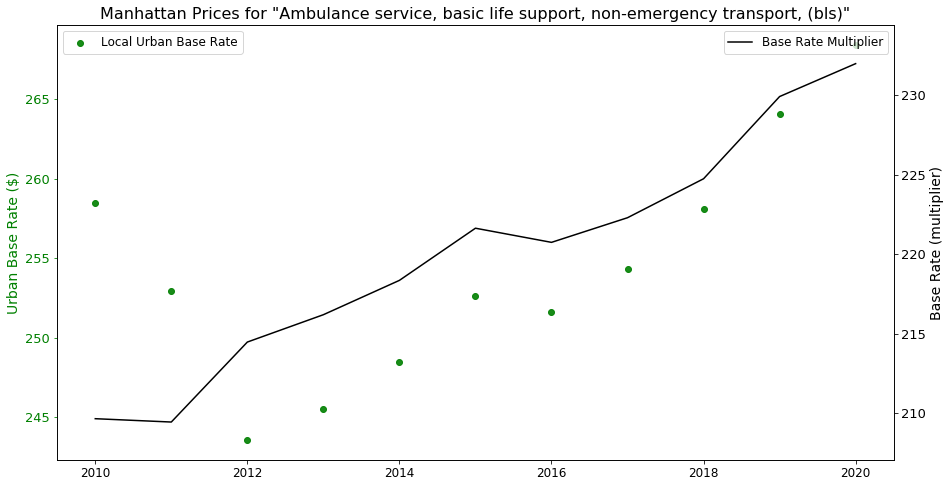

In [72]:
# Call the city_time_plotter function with HCPCS, state, and city of interest
city_time_plotter(hcpcs='A0428', carrier='empire new york', locality='manhattan')

In [20]:
# Create a function to create a bar plot of ambulance fees for a particular year, state, and city
def city_bar_plotter(year=2020, carrier='texas', locality='austin'):
    
    # List of ambulance fees not to include in visualization (due to being per mile costs)
    lst = ['A0436', 'A0435', 'A0425']
    
    # Create temporary df with year and state of interest
    df_temp = df.loc[(df['year']==year) & (df['contractor/carrier name'] == carrier) & (~df['hcpcs'].isin(lst)) & (df['locality name']==locality)].copy()
    
    # Perform groupby to find median cost for state. Grouped by HCPCS description
    data = df_temp.groupby(['short description'])[['urban base rate / urban mileage']].median().sort_values("urban base rate / urban mileage")
    
    try:
        # Reformat name to uppercase and define str variable for title of plot
        name = df_temp['locality name'].values[0]
        name = name[0].upper() + name[1:]
    except:
        # If the user enters an unknown carrier / state ...
        return 'No data for this carrier'
    
    # Create horizontal bar plot
    data.plot.barh(figsize=(12,8), color='b', alpha=0.4, fontsize=MEDIUM_SIZE)
    # Format plot
    plt.title('Median Fee for Ambulance Services in ' + name, fontsize=BIGGER_SIZE)
    plt.xlabel('Cost ($)', fontsize=MEDIUM_SIZE)
    plt.ylabel('')
    plt.legend(prop={'size': 12}, loc=4)
    plt.show()

In [73]:
# Print out all cities for a particular state so the user can use them in the graphs
print('All cities in the state: \n')
city_list(state='empire new york')

All cities in the state: 

manhattan || nyc suburbs/long i. || poughkpsie/n nyc suburbs || nyc suburbs/long island || 

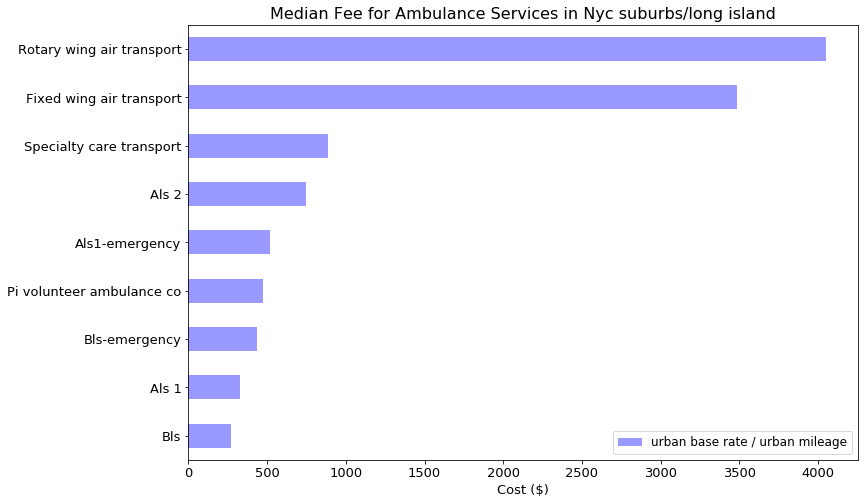

In [59]:
# Call the city_bar_plotter for the year, state, and city of interest
city_bar_plotter(year=2020, carrier='empire new york', locality='nyc suburbs/long island')

### 3 - Business Application<a class="anchor" id="business_app_3"></a>
Let us assume the following scenario:
* A hospital operates an ambulance service
* They have data on how many monthly ambulance calls have occured over the past 10 years
* They want to project their revenue for the next few years before the ambulance fee schedule comes out

To accomplish this goal let us:
* Perform simple linear regression on the ambulance fee schedule for that location
* Perform ARIMA time series forecasting on their historical monthly call data
* Combine the regression and time series forecast to get revenue

#### 3.1 - Ambulance Fee Schedule Regression<a class="anchor" id="business_app_regr_3_1"></a>

In [22]:
# Define function to grab data for a particular HCPCS code, state, and city
def df_city_data(hcpcs='A0428', carrier='texas', locality='austin', df=df):
    df_temp = df.loc[(df['hcpcs']==hcpcs) & (df['contractor/carrier name'] == carrier) & (df['locality name'] == locality)].copy()
    return df_temp

In [23]:
# Grab data for Austin, TX
df_austin = df_city_data(hcpcs='A0428', carrier='texas', locality='austin', df=df)
df_austin.head(2)

,year,contractor/carrier,contractor/carrier name,locality,locality name,hcpcs,short description,long description,base rate,rvu,gpci,urban base rate / urban mileage,rural base rate / rural mileage,rural base rate / lowest quartile,rural ground miles
603,2010,04402,texas,31.0,austin,A0428,Bls,"Ambulance service, basic life support, non-eme...",209.65,1.0,0.992,212.65,214.73,263.26,NaN
603,2011,04402,texas,31.0,austin,A0428,Bls,"Ambulance service, basic life support, non-eme...",209.44,1.0,0.995,212.88,214.97,263.55,NaN


Equation of the line: y = 3x + -5450

The R^2 score: 0.959 

The predicted ambulance fees are:  [244.0, 246.0]


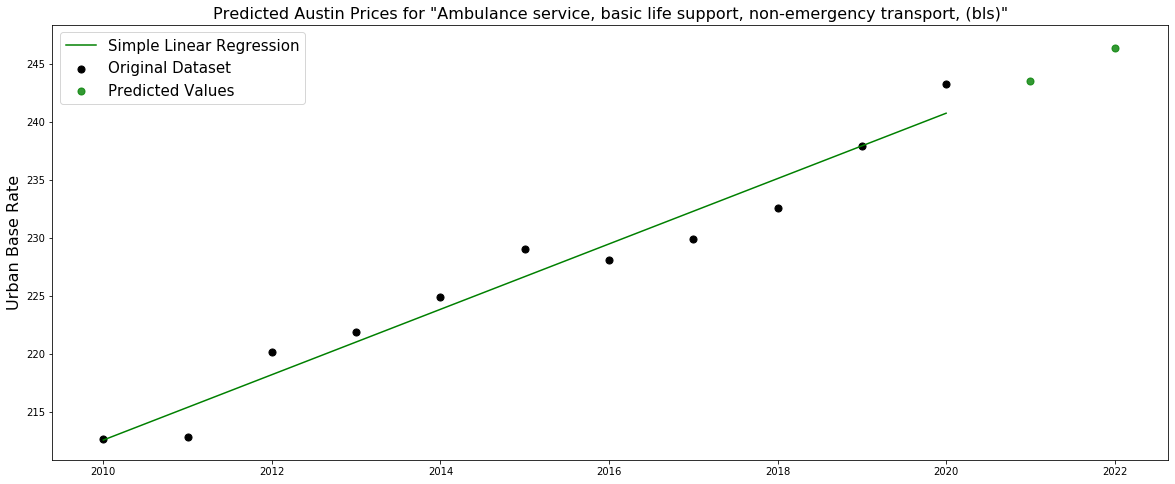

In [74]:
# Import correct modules
from sklearn.linear_model import LinearRegression

# Create linear model instance
lm = LinearRegression()

# Define X an y
X = df_austin[['year']]
y = df_austin['urban base rate / urban mileage']

# Fit the X and Y data
lm.fit(X, y)

# Get equation of the line
print('Equation of the line: y = ', round(lm.coef_.item()),'x + ', round(lm.intercept_.item()),'\n', sep='')

# See how this scores on the data
print('The R^2 score:', round(lm.score(X, y), 3),'\n')

# Format name to display in plot title
name = df_austin['locality name'].values[0]
name = name[0].upper() + name[1:]

# Make predictions i # of years in the future
yrs = 2
lst_pred = [X.values.flatten()[-1] + i for i in range(1,yrs + 1)]
X_pred = pd.DataFrame(lst_pred)
print('The predicted ambulance fees are: ', list(map(round, lm.predict(X_pred))))

# Create and format scatter plot to visualize data, regression, and predictions
fig, ax = plt.subplots(figsize=(20,8))
plt.scatter(X,y, label="Original Dataset", c='k', s=50)
plt.scatter(X_pred,lm.predict(X_pred), c='g', label="Predicted Values", alpha=0.8, s=50)
plt.plot(X, lm.predict(X), c='g', lw=1.5, label='Simple Linear Regression')
plt.xlabel('')
plt.ylabel('Urban Base Rate', size=BIGGER_SIZE)
plt.title('Predicted ' + name + ' Prices for "' + df_austin['long description'].values[0] + '"', size=BIGGER_SIZE)
plt.legend(loc=2, prop={'size': 15})
plt.show()

#### 3.2 - Revenue Forecasting<a class="anchor" id="business_app_rev_3_2"></a>

In [25]:
temp = pd.read_csv('./_fake_data/air_temp.csv')
temp.loc[~temp['TOBS'].isna()].head(2)

,STATION,DATE,TAVG,TMAX,TMIN,TOBS
56928,USC00154955,2011-01-01,NaN,62.0,29.0,29.0
56929,USC00154955,2011-01-02,NaN,35.0,21.0,28.0


In [26]:
temp['DATE'].to_datetime(format='%Y%m%d', errors='ignore')

AttributeError: 'Series' object has no attribute 'to_datetime'

#### 3.2 - Statewide<a class="anchor" id="business_app_rev_3_2"></a>

In [ ]:
# df.groupby(['long description']).agg({'urban base rate / urban mileage': ['mean', 'max']})

In [ ]:
df.loc[(df['year'] == 2016)].sample(10)

In [ ]:
for code in df['hcpcs'].unique().tolist()[1:4]:

    df_temp = df.loc[df['hcpcs']==code].copy()

    # Create figure instance
    fig, ax = plt.subplots(figsize=(10,6))

    # Create scatter plot of urban mileage prices
    x = df_temp['year']
    y = df_temp['urban base rate / urban mileage']
    ax.scatter(x, y, color='g', alpha=0.1, label='Local Urban Mileage Price')
    ax.set_ylabel('Urban Base Rate ($)', color="g",fontsize=14)
    ax.tick_params(axis='y', colors='g', labelsize=10)
    ax.tick_params(axis='x', labelsize=12)

    plt.legend(prop={'size': 12})
    # Create plot of base rate increases on secondary y axis
    ax2=ax.twinx()
    ax2.plot(x, df_temp['base rate'], color="k", label='Base Rate Multiplier')
    ax2.set_ylabel("Base Rate (multiplier)",color="k",fontsize=14)
    ax2.tick_params(axis='y', colors='k', labelsize=10)
    median = df_temp['base rate'].median()
    dif = ax.get_ylim()[1] - ax.get_ylim()[0]
    ax2.set_ylim(median - dif/2, median + dif/2)

    plt.xlabel('Year')

    plt.title('Nationwide Prices of "' + df.loc[df['hcpcs']==code]['short description'].values[0] + '" (HSCBC Code: ' + code + ')', size=15)
    plt.legend(prop={'size': 12})
    plt.show()